<a href="https://colab.research.google.com/github/broadinstitute/BEClust3D/blob/main/BEClust3D_v1_SingleScreen_SingleGene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Steps

In [ ]:
# @title Imports
# @markdown Import BEClust3D from Github and other necessary packages
! pip uninstall beclust3d -y
! pip install git+https://github.com/broadinstitute/BEClust3D.git@preprocess_be_results
! pip install pandas
! pip install numpy
! pip install matplotlib

  Cloning https://github.com/broadinstitute/BEClust3D.git (to revision preprocess_be_results) to /tmp/pip-req-build-kkvda36f
  Running command git clone --filter=blob:none --quiet https://github.com/broadinstitute/BEClust3D.git /tmp/pip-req-build-kkvda36f
  Running command git checkout -b preprocess_be_results --track origin/preprocess_be_results
  Switched to a new branch 'preprocess_be_results'
  Branch 'preprocess_be_results' set up to track remote branch 'preprocess_be_results' from 'origin'.
  Resolved https://github.com/broadinstitute/BEClust3D.git to commit 6ce7f6d4cdae6e4ed5121d0eee7af9447d3e56b2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.5 MB/s eta 0:00:00
  Created wheel for beclust3d: filename=beclust3d-2024.0.

In [ ]:
# @title Imports
# @markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title Import Google Drive
# @markdown Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @markdown If files are in Google Drive, add 'drive/' in front of path
workdir = '' # @param {type:"string"}

In [ ]:
# @markdown Separate screen file names by comma
screens = 'Human_InVitro_294T_Apobec_D14_Input.txt' # @param {type:"string"}
screens = screens.split(',')

input_gene = 'SETDB1' # @param {type:"string"}
input_uniprot = 'Q15047' # @param {type:"string"}
structureid = f"AF-{input_uniprot}-F1-model_v4"

# Query Structure and Conservation, and Preprocess Screens

In [ ]:
# @markdown Query Uniprot and AlphaFold and process files

from beclust3d.af_structural_features import af_structural_features

af_structural_features(
    workdir=workdir,
    input_gene=input_gene,
    input_uniprot=input_uniprot,
    structureid=structureid
    )

,unipos,unires,x_coord,y_coord,z_coord,bfactor_pLDDT,Naa_count,Naa,Naa_pos,SS9,...,ACC,RSA,exposure,PHI,normPHI,PSI,normPSI,dBurial,normSumdBurial,pLDDT_dis
0,1,M,40.740,39.109,-6.115,36.75,1,S,2,L,...,233,1.04,exposed,360.0,2.00,157.3,0.87,0.00,0.000,very low
1,2,S,37.812,38.895,-3.704,32.83,2,M;S,1;3,L,...,103,0.66,medexposed,35.4,0.20,133.7,0.74,0.38,0.076,very low
2,3,S,35.498,37.485,-2.174,32.79,2,S;L,2;4,L,...,99,0.64,medexposed,179.7,1.00,177.6,0.99,0.40,0.120,very low
3,4,L,32.875,36.126,0.319,42.90,2,S;P,3;5,L,...,165,0.82,exposed,94.0,0.52,156.7,0.87,0.22,0.079,very low
4,5,P,31.112,32.952,1.735,39.74,2,L;G,4;6,L,...,115,0.72,medexposed,-102.6,-0.57,165.8,0.92,0.32,0.090,very low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,1287,R,3.341,-6.712,-10.508,85.91,3,C;G;R,1286;1288;1289,L,...,104,0.42,medburied,-63.4,-0.35,-9.9,-0.06,0.62,0.552,confident
1287,1288,G,5.709,-4.495,-12.671,86.20,6,E;D;C;C;R;R,1146;1147;1279;1286;1287;1289,S,...,9,0.09,buried,71.4,0.40,-39.9,-0.22,0.95,0.798,confident
1288,1289,R,2.800,-4.128,-15.192,86.79,7,L;L;C;R;G;L;L,1277;1278;1279;1287;1288;1290;1291,B,...,69,0.28,medburied,-126.4,-0.70,162.4,0.90,0.76,0.616,confident
1289,1290,L,-0.974,-3.633,-15.073,80.70,7,Y;V;L;L;C;R;L,1267;1269;1277;1278;1279;1289;1291,L,...,11,0.05,buried,-104.3,-0.58,-44.6,-0.25,0.99,0.733,confident


Count of Nonsense rows: 33
Count of Splice Site rows: 19
Count of Missense rows: 282
Count of No Mutation rows: 168
Count of Silent rows: 109


{'Human_InVitro_294T_Apobec_D14_Input': {'Nonsense':    this_edit edit_pos refAA altAA    LFC
  4       Q70*       70     Q     * -0.531
  5      Q273*      273     Q     * -0.404
  6      Q436*      436     Q     * -0.306
  13     R616*      616     R     * -0.205
  14     R390*      390     R     * -1.034
  17     Q148*      148     Q     * -0.839
  18     Q888*      888     Q     * -0.143
  20    Q1084*     1084     Q     *  0.826
  21     R616*      616     R     * -0.004
  22      Q26*       26     Q     *  0.220
  24     Q758*      758     Q     *  0.273
  25      Q70*       70     Q     * -1.853
  28     R366*      366     R     * -1.389
  29     R495*      495     R     *  0.848
  31    Q1122*     1122     Q     * -0.058,
  'Splice Site': 0    -0.389
  1    -0.665
  2    -0.689
  3    -1.405
  4     0.168
  5     0.290
  6    -1.214
  7    -2.226
  8    -0.891
  9    -0.677
  10   -0.405
  11   -0.522
  12    0.814
  13    1.233
  14    0.389
  15   -0.271
  16    1.121
  17   

<Figure size 640x480 with 0 Axes>

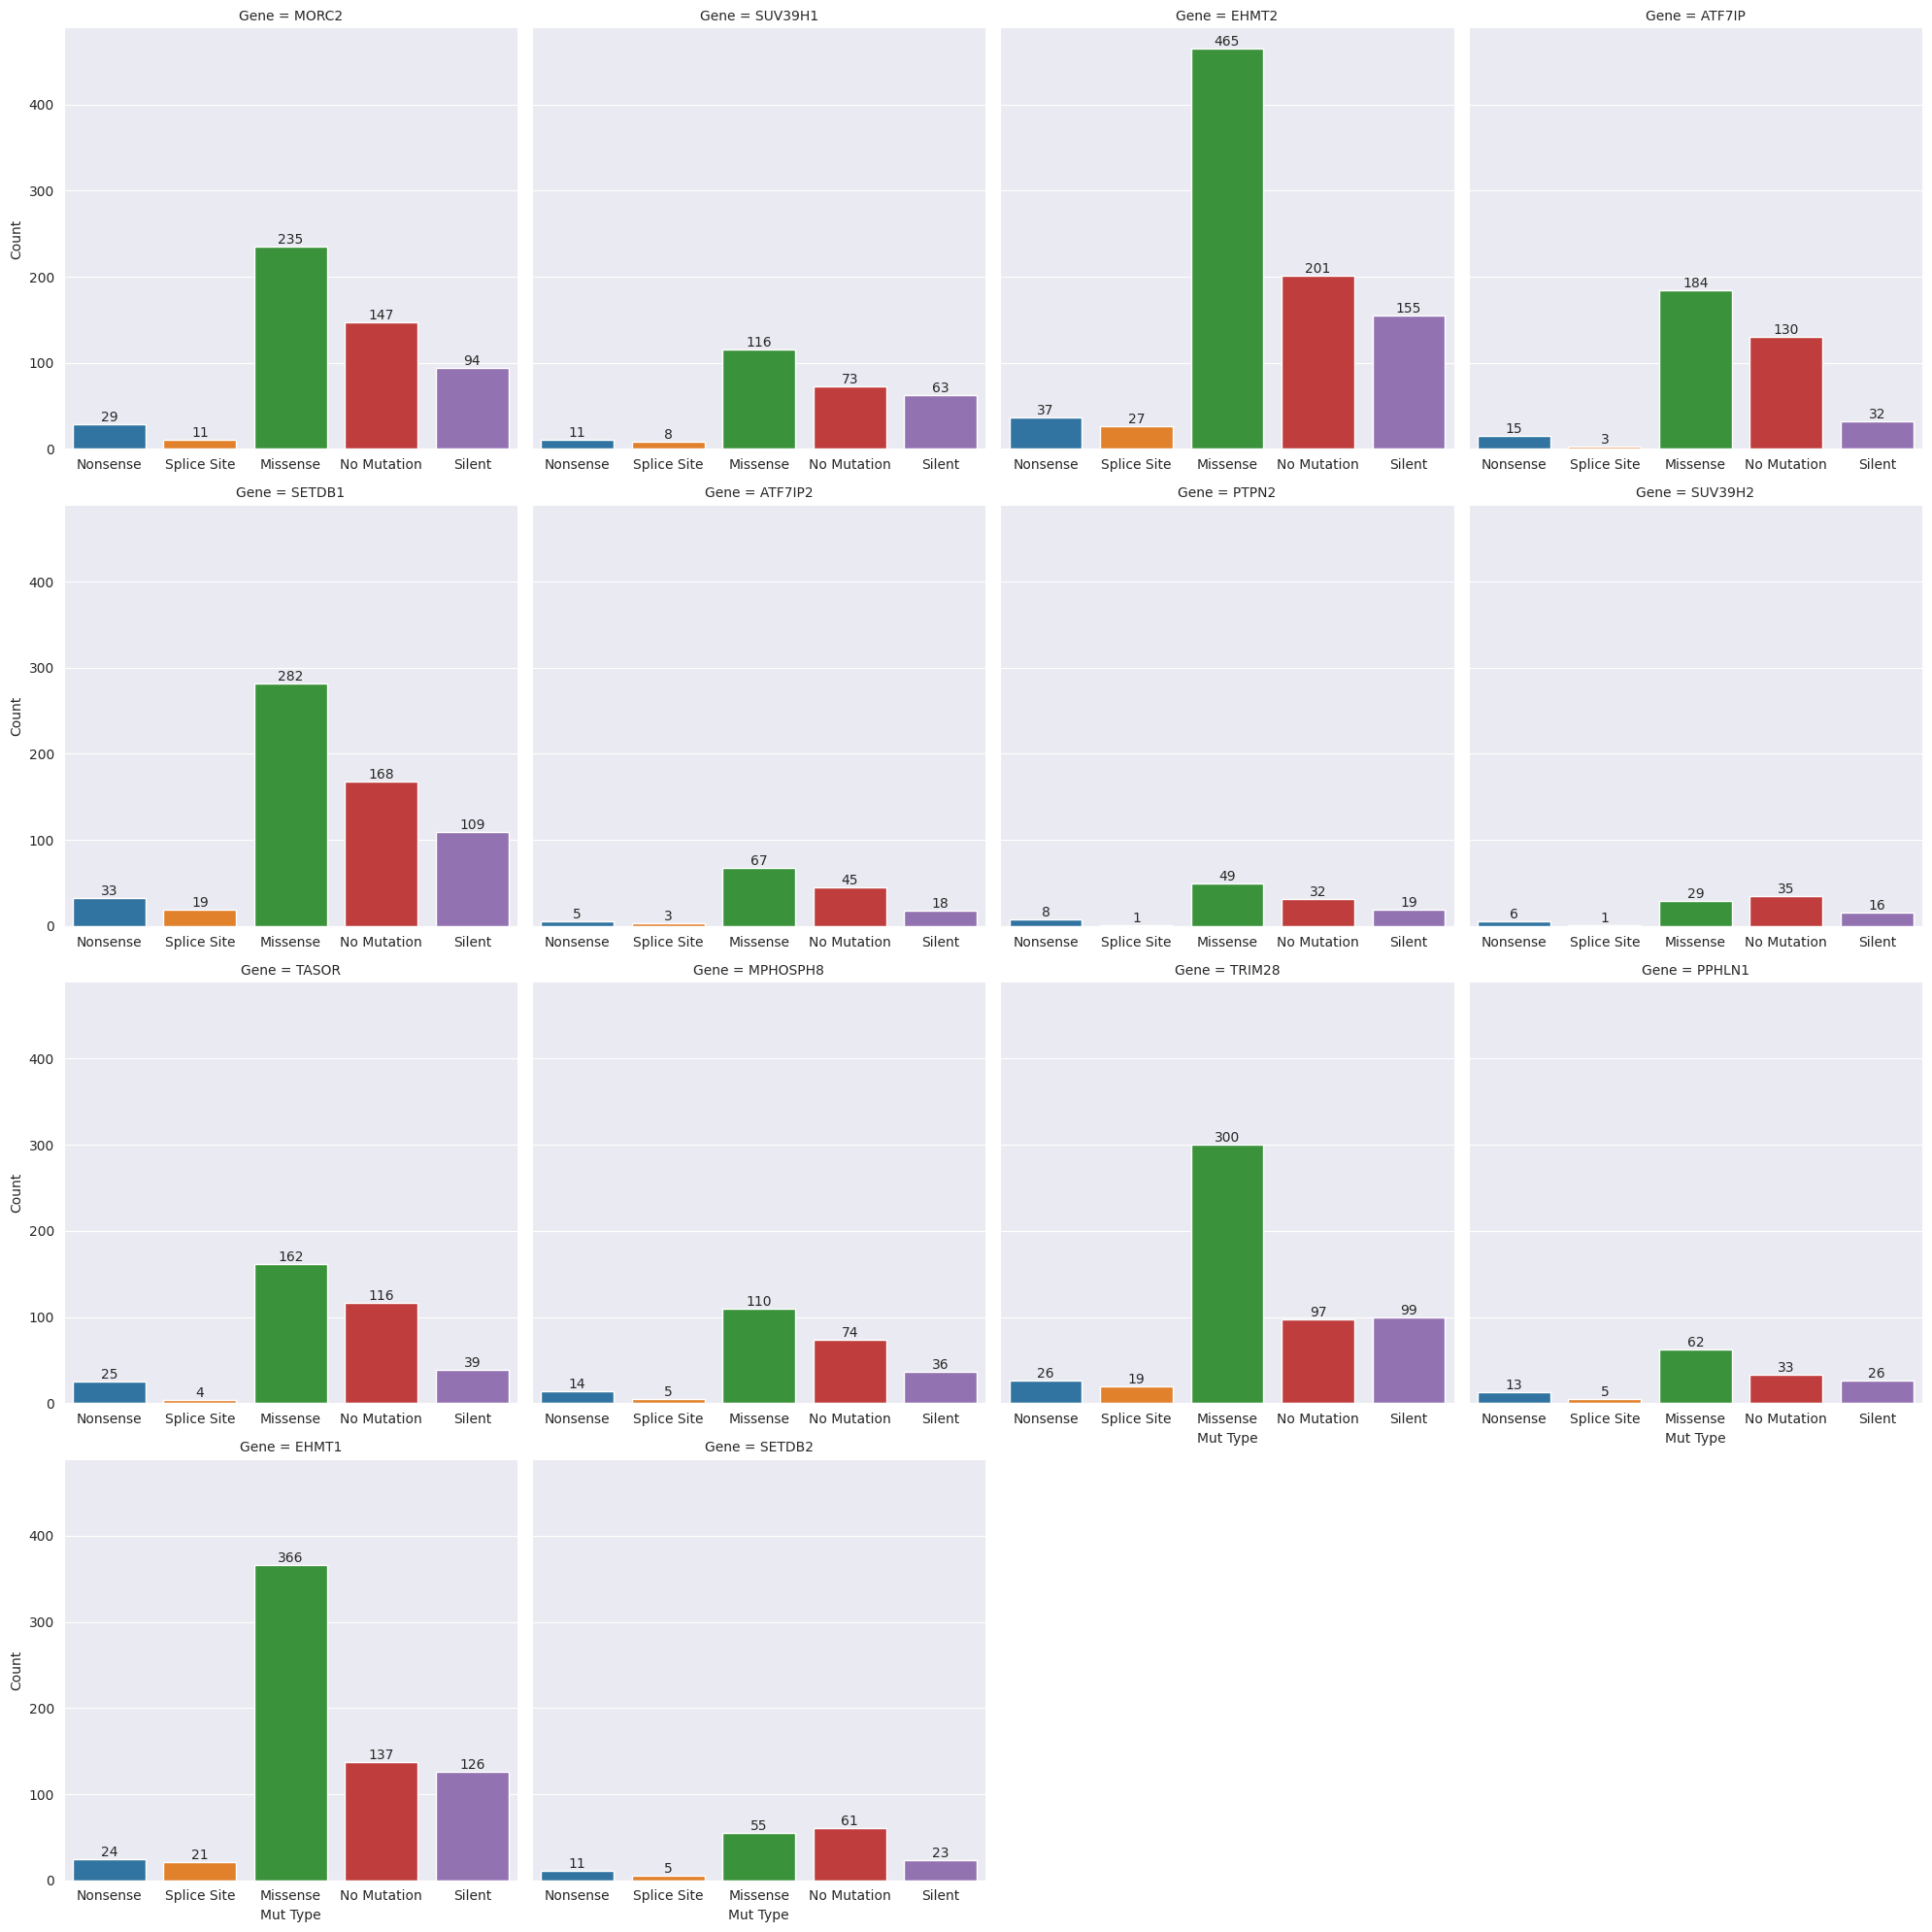

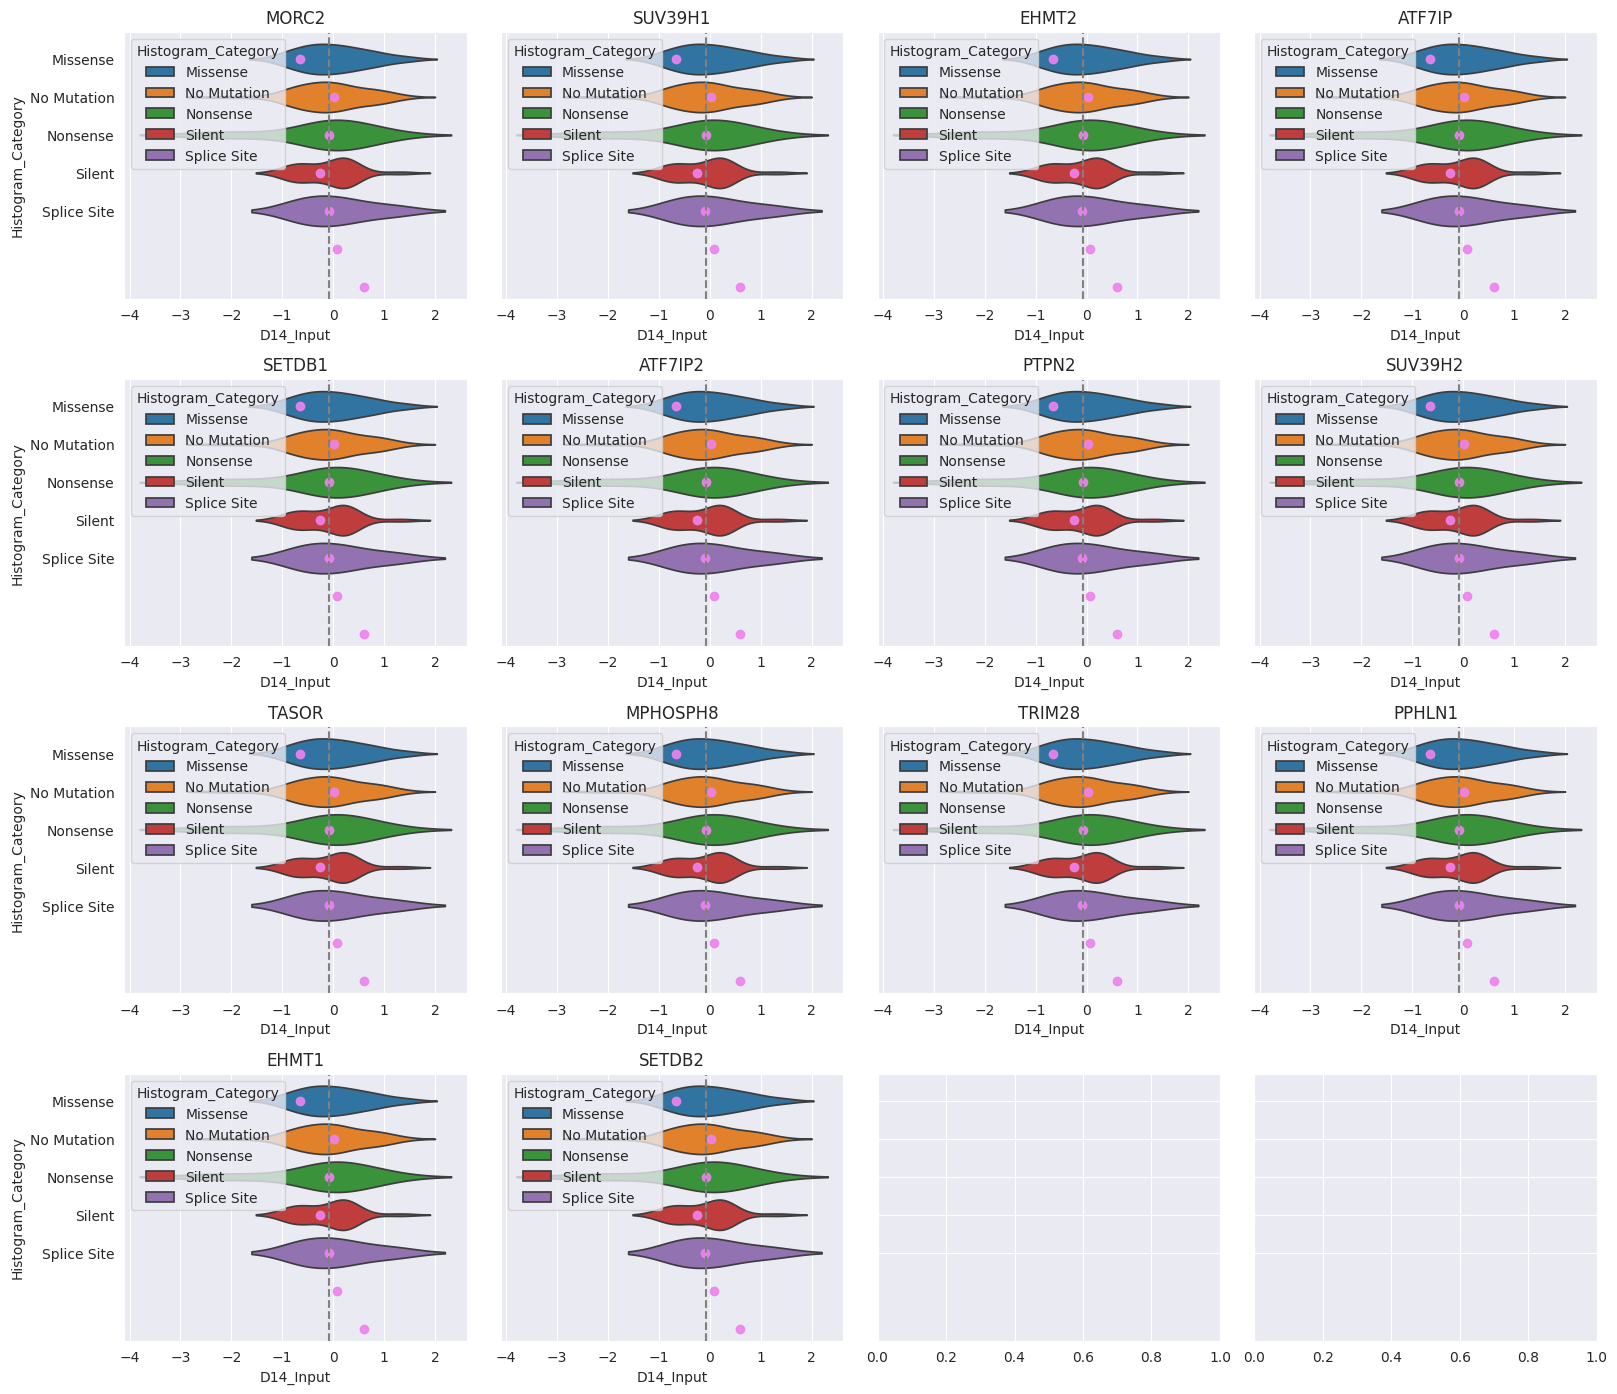

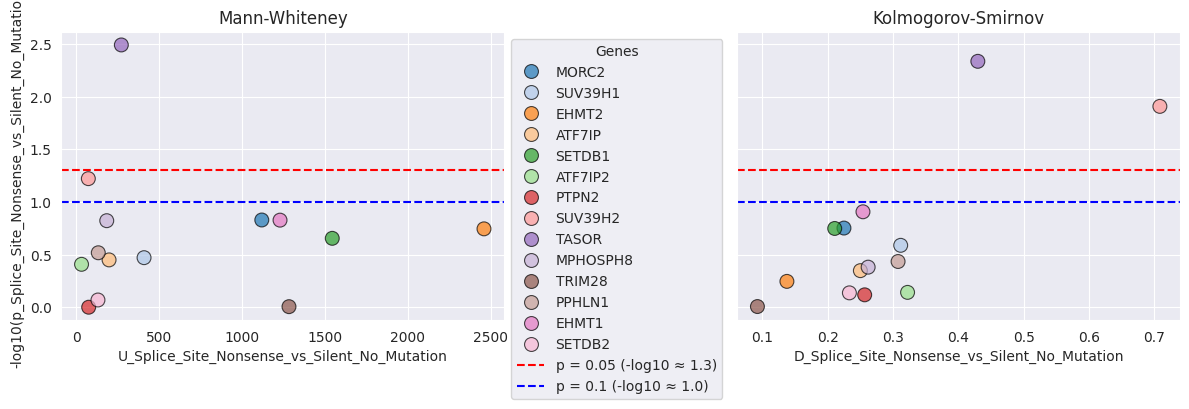

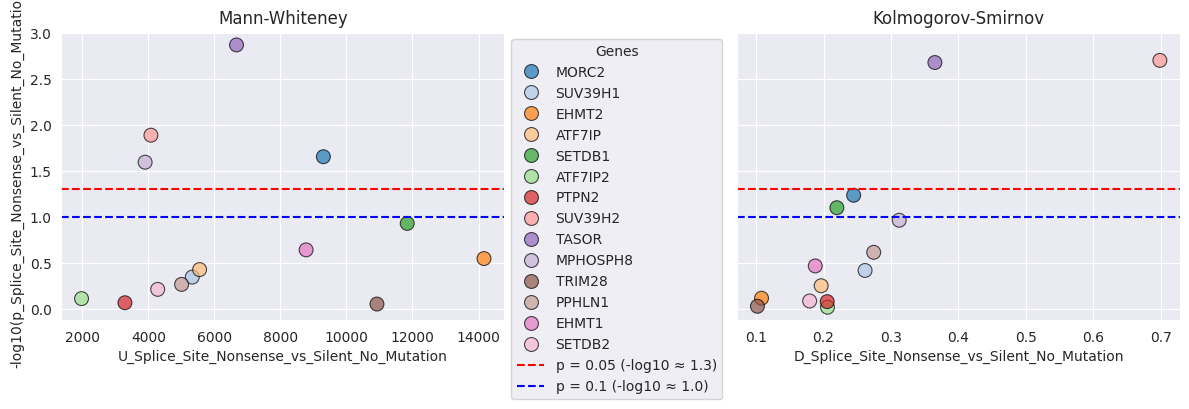

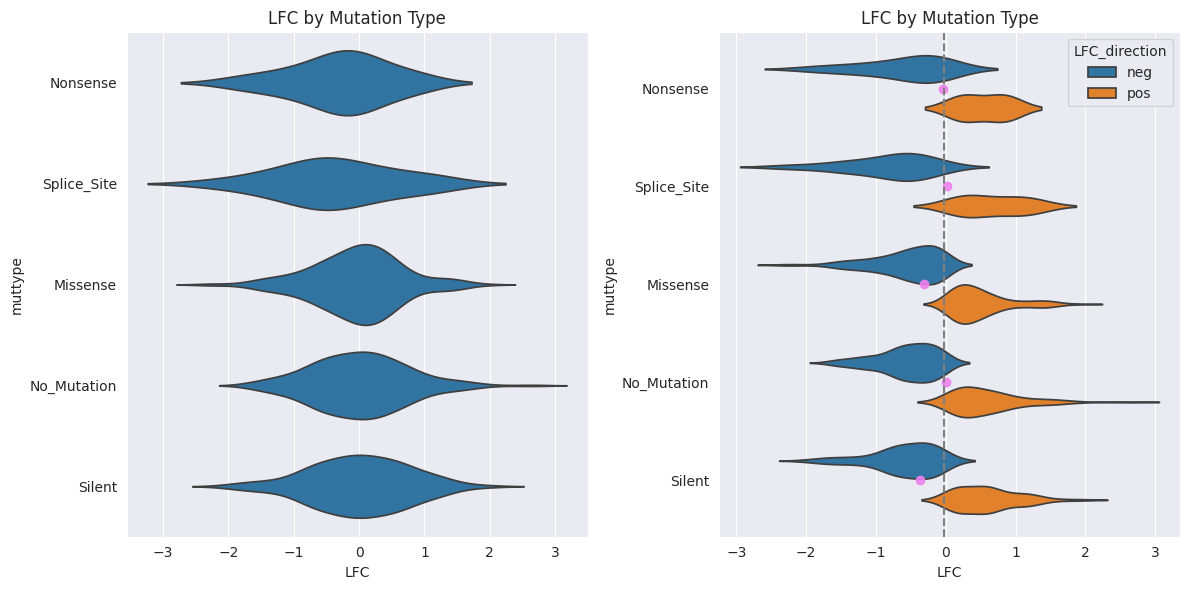

In [ ]:
# @markdown Preprocess screen data and QC plots

from beclust3d.preprocess_be_results import parse_base_editing_results

df_inputs = [pd.read_csv(f'rawdata/{screen}', sep='\t') for screen in screens]
parse_base_editing_results(
    df_Inputs = df_inputs,
    workdir = workdir, input_gene = input_gene, input_screens = screens,
    mut_col='Histogram_Category', val_col='D14_Input',
    gene_col='TargetGeneSymbol', edits_col='AminoAcidEdits',
    )

In [ ]:
# @markdown Randomize screen data

from beclust3d.randomize_be_results import randomize_be_results

screen_names = [screen.split('.')[0] for screen in screens]
df_missenses = [pd.read_csv(f'SETDB1/screendata/{input_gene}_{screen_name}_Missense_edits_list.tsv', sep='\t') for screen_name in screen_names]
for df_missense, screen_name in zip(df_missenses, screen_names):
    randomize_be_results(
        df_missense=df_missense,
        workdir=workdir,
        input_gene=input_gene,
        input_screen=screen_name,
        )

In [ ]:
# @markdown Query conservation MUSCLE

from beclust3d.conservation import conservation

input_mouse_gene = 'Setdb1' # @param {type:"string"}
input_mouse_uniid = 'D3YYC3' # @param {type:"string"}

df_alignconserv, df_residuemap = conservation(
    workdir=workdir,
    input_human_gene=input_gene, input_mouse_gene=input_mouse_gene,
    input_human_uniid=input_uniprot, input_mouse_uniid=input_mouse_uniid,
    email='xiaohu@g.harvard.edu', title='samplejob',
    )

Job ID: muscle-R20240813-195656-0654-76008832-p1m


In [ ]:
# @markdown Prioritize screen data by conservation

from beclust3d.prioritize_by_conservation import prioritize_by_conservation

df_struc = pd.read_csv(f"{input_gene}/{structureid}_coord_struc_features.tsv", sep = "\t")
df_consrv = pd.read_csv(f"{input_gene}/Human{input_gene}_MouseSetdb1_residuemap_conservation.tsv", sep = '\t')
for screen in screens:
    out_df = prioritize_by_conservation(
            df_struc     =df_struc,
            df_consrv    =df_consrv,
            workdir      =workdir,
            input_gene   =input_gene,
            input_screen =screen,
            structureid  =structureid,
        )

In [ ]:
# @markdown Randomize screen data prioritized by conservation

from beclust3d.randomize_by_conservation import randomize_by_conservation

for screen in screens:
    out_df = randomize_by_conservation(
        workdir      =workdir,
        input_gene   =input_gene,
        input_screen =screen,
        structureid  =structureid,
    )

# Calculate 3D LFC Scores and